In [2]:
# Import python packages
import pickle

# imoprt data science libraries
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import numpy as np

# Import ML libraries
import keras
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from keras import layers
from keras import ops

# local module with helper utils
import model_utils as mutils
from model_utils import imb_ratio
from model_utils.evaluation import evaluate_model, get_metrics

In [51]:
# Load pre-processed data

current_k_fold = 10
# set seed
SEED=current_k_fold**3
np.random.seed(SEED)

# pandas options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# deserialize pre-processed data
path_to_pickle = f'../data/creditcard/cc13_preprocessed_k{current_k_fold}.pkl'

with open(path_to_pickle, "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]

    X_val = data["X_val"]
    y_val = data["y_val"]

    X_test = data["X_test"]
    y_test = data["y_test"]

    col_names = data["col_names"]

print("Data loaded successfully")

# get imbalance ratio for each data set
IR_train = imb_ratio(y_train.value_counts())
IR_val = imb_ratio(y_val.value_counts())
IR_test = imb_ratio(y_test.value_counts())

# print imbalance ratios. They should be (nearly) the same. pct = 0.172 such as in the paper!
print(f"Imbalance ratio in training data: {IR_train}")
print(f"Imbalance ratio in validation data: {IR_val}")
print(f"Imbalance ratio in test data: {IR_test}")

# print number of samples in each data set
print(f"\nNumber of samples in training data: {len(y_train)}")
print(f"Number of samples in validation data: {len(y_val)}")
print(f"Number of samples in test data: {len(y_test)}")

# Normalize Data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## AE specific pre-processing: Only use negative samples for training
X_train = X_train[y_train == 0].copy()
neg_y_train = y_train[y_train == 0].copy() # TODO: check if this is necessary

X_val = X_val[y_val == 0].copy()
neg_y_val = y_val[y_val == 0].copy()

Data loaded successfully
Imbalance ratio in training data: 599.48
Imbalance ratio in validation data: 590.1
Imbalance ratio in test data: 602.68

Number of samples in training data: 226980
Number of samples in validation data: 28373
Number of samples in test data: 28373


In [7]:
df(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,-1.091376,0.691290,-0.361072,-1.621804,-0.376239,0.162944,0.013374,1.130966,0.300410,-1.857587,-0.055176,1.727381,0.697013,0.936558,-0.479959,-0.012276,-0.318521,0.228430,0.444951,-0.596038,-0.024273,-0.149033,-0.058422,-1.890986,0.602458,-1.974261,-0.275232,-0.544472,0.002845
1,-0.281300,0.547709,1.011262,-0.171894,0.255836,0.286769,0.384921,0.294546,-0.634088,-0.223047,1.749133,0.919302,0.096633,0.376335,0.690642,-0.236091,-0.108663,-0.941749,-0.520066,0.083337,-0.159920,-0.324332,0.052494,-0.499798,-0.696766,0.233794,0.731220,0.313268,-0.320814
2,0.971042,-0.571920,0.192019,0.484524,-0.830664,0.435632,-0.998787,0.227673,2.162340,-0.322336,-2.175909,0.728622,0.165062,-1.286083,-1.819249,-0.178970,-0.030361,-0.339709,0.800296,-0.185268,-0.214516,0.070125,0.251378,-0.845088,-0.661255,1.256822,0.044732,-0.126638,-0.215464
3,-0.387389,0.338617,0.765876,-1.144115,0.270669,-0.490092,0.717457,-0.451462,-1.402010,0.636031,-0.734085,-0.749598,1.110155,-0.594961,0.388957,0.967501,-0.039724,-1.954118,1.657148,0.449344,-0.353175,-0.822948,-0.609686,-0.741952,0.912504,-0.895644,-0.291956,-0.367085,-0.193435
4,1.040169,-0.262296,-0.533720,0.116199,-0.152911,0.076560,-0.546540,0.098190,1.327957,-0.074241,-1.564312,-0.447179,-0.767491,0.154616,1.366819,0.576826,-0.993726,0.707660,-0.205077,-0.306199,0.217352,0.756345,0.172786,0.012247,-0.152319,-0.472595,0.056046,-0.118450,-0.316337


In [4]:
# VAE Keras Custom Model Class 

# Code based on Bank et al. (2021)
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, kl_beta=1, **kwargs):
        super().__init__(**kwargs)
        self.decoder = decoder
        self.encoder = encoder
        self.loss_tracker =  keras.metrics.Mean(name="loss")
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.kl_beta = kl_beta # weight to put more or less balance on reconstruction loss
        
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
    
    @tf.function
    def reconstruction_loss(self, x, f_z):
        # reconstruction_loss = keras.losses.binary_crossentropy(x, f_z)
        mse = keras.losses.MeanSquaredError()
        reconstruction_loss = mse(x, f_z)

        return reconstruction_loss
    
    @tf.function
    def loss_fn(self, x, f_z, z_mean, z_log_var):
        # Ensure reduction across the batch dimension
        reconstruction_loss = tf.reduce_mean(self.reconstruction_loss(x, f_z))
        
        # KL divergence calculation
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # total loss calculation
        total_loss = reconstruction_loss + (self.kl_beta * kl_loss)
        return total_loss, reconstruction_loss, kl_loss
    
    @staticmethod # Define the encoder model. See Bank et al (2021, p 8)
    def get_encoder(data_dim, latent_dim, hidden_dims, activation=keras.layers.ReLU(), dropout_rate=0): 
        """ Encoder Net
        
        Takes input x and maps it into a mean and covariance that determine the approximate posterior distribution of the latent space.

        Args:
            data_dim (_type_): Input dimension. Usually equal to n features.
            latent_dim (_type_): Size of the bottleneck.
            hidden_dims: List of hidden dims, e.g., [20, 10, 8]
            activtion: Activtion function for hidden dims

        Returns:
            z_mean: Mean
            z_log_var: Covariance
        """
        # Input Layer
        inputs = layers.Input(shape=(data_dim,))
        
        # Hidden Layer for compression
        x = inputs
        for dim in hidden_dims:
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)
              
        # calculate mean g(x) and covariance h(x) of the distribution
        z_mean = layers.Dense(latent_dim)(x)
        z_log_var = layers.Dense(latent_dim)(x)

        return keras.Model(inputs, [z_mean, z_log_var], name='encoder')
    
    @staticmethod # Define the decoder model f(z)
    def get_decoder(latent_dim, output_dim, hidden_dims, activation=keras.layers.ReLU(), dropout_rate=0):
        # take sample from latent space as input
        latent_inputs = layers.Input(shape=(latent_dim,))
        
        # Hidden Layer for reconstruction
        x = latent_inputs
        for dim in reversed(hidden_dims):
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)
        
        # output reconstruction
        outputs = layers.Dense(output_dim, activation='sigmoid')(x)
        return keras.Model(latent_inputs, outputs, name='decoder')
    
    def sampling(self, args): # Define the sampling function. See Bank et al (2021, p 8)
        """ Sample from latent space by applying 'Reparameterization'

        Args:
            args (list): List of mean and covariance (z_mean, z_log_var)

        Returns:
            z: Sample from the latent space
        """
        # unpack mean g(x) and covariance h(x)
        z_mean, z_log_var = args
        
        # epsilon is a normal distribution: N(0, I)
        epsilon = keras.random.normal(shape=tf.shape(z_mean), seed=self.seed_generator)
        
        # Sampling via reparametrisation trick: z = h(x)  * espilon + g(x)
        return epsilon * ops.exp(z_log_var * .5) + z_mean

    @tf.function
    def train_step(self, data):
        # data = random minibatch of M datapoints
        x = data
        
        with tf.GradientTape() as tape:
            # encode input to mean g(x) and covariance h(x)
            z_mean, z_log_var = self.encoder(x)
            
            # sample random z from latent space
            z = self.sampling((z_mean, z_log_var))
            
            # decode z via f(z)
            f_z = self.decoder(z)

            # calculate reconstruction loss
            loss, reconstruction_loss, kl_loss = self.loss_fn(x, f_z, z_mean, z_log_var)
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.loss_tracker.update_state(loss)         
        
        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }
        
    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x)
        
        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)
        
        _, reconstruction_loss, _ = self.loss_fn(x, f_z, z_mean, z_log_var)
        return {
            "reconstruction_loss": reconstruction_loss,
        }

    def call(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x)
        
        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)
            
        return self.reconstruction_loss(x, f_z)

## Train/Load the model

### some notes from Bank et al. (2021)

- "Its important to note that even if the 𝑏𝑜𝑡𝑡𝑙𝑒𝑛𝑒𝑐𝑘 is comprised of only one node, then overfitting is still possible if the capacity of the encoder and the decoder is large enough to encode each sample to an index."

- "In cases where the size of the hidden layer is equal or greater than the size of the input, there is a risk that the encoder will simply learn the identity function."

- reconstruction loss is not a measure for how realistc xhat is!

- there's a trade off between getting the best possible reconstruction and the best possible latent space representation. So, the model should be trained with a balance between the two.

In [52]:
batch_size = 100

# "tensorize" & batch X_train
dataset = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
batches = dataset.shuffle(buffer_size=1024).batch(batch_size)  # Batch the dataset

Hyperparams:
______________________________
Data Dimension (Features):  29
Latent Dim (z):  7
Batchsize:  100
Epochs:  100
Learning Rate:  0.0001
KL beta 0.3
Hidden Dims:  [14, 10]
Activation Function:  <ReLU name=re_lu_15, built=False>
Dropout Rate:  0.2
______________________________ 

Epoch 1/100
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step - kl_loss: 134764.7969 - loss: 22689.9297 - reconstruction_loss: 1.0893 - val_reconstruction_loss: 0.9121
Epoch 2/100
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - kl_loss: 17437.7754 - loss: 2930.2712 - reconstruction_loss: 0.9705 - val_reconstruction_loss: 0.8956
Epoch 3/100
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - kl_loss: 7339.5376 - loss: 1253.9312 - reconstruction_loss: 0.9675 - val_reconstruction_loss: 0.8928
Epoch 4/100
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - kl_loss: 2650.6797 - loss: 455.0411 - reconstruction_loss: 0.9670 - val_reconstruction_loss: 0.8931
Epoch 5/100
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - kl_loss: 

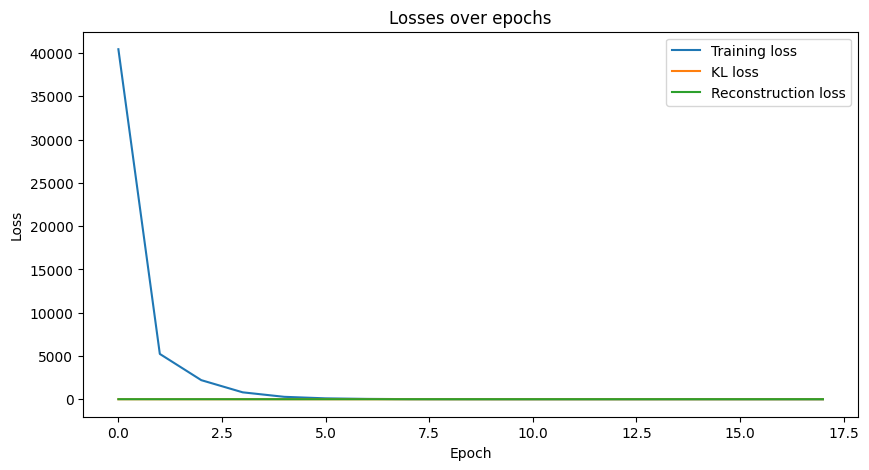

In [53]:
# hyperparams
data_dim = X_train.shape[1]

latent_dim = 7 # size of the "bottleneck" / latent space.
# NOTE: If latent_dim = 1, Overfitting is still possible if NN capacity is high enough (Bank et al. (2021, p. 3))

epochs = 100
learning_rate=0.0001

kl_beta = 0.3
hidden_dims = [14, 10]
activation = keras.layers.ReLU()
dropout_rate = 0.2

#optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer=keras.optimizers.SGD(learning_rate=learning_rate)
#optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate)

print("Hyperparams:")
print("_"*30)
print("Data Dimension (Features): ", data_dim)
print("Latent Dim (z): ", latent_dim)
print("Batchsize: ", batch_size)
print("Epochs: ", epochs)
print("Learning Rate: ", learning_rate)
print("KL beta", kl_beta)
print("Hidden Dims: ", hidden_dims)
print("Activation Function: ", activation)
print("Dropout Rate: ", dropout_rate)
print("_"*30, "\n")

# Construct VAE model with given hyperparams
enc = VAE.get_encoder(data_dim, latent_dim, hidden_dims, activation, dropout_rate)
dec = VAE.get_decoder(latent_dim, data_dim, hidden_dims, activation, dropout_rate)
vae = VAE(enc, dec, kl_beta)
vae.build((None, data_dim))  # None indicates batch size can vary
vae.compile(optimizer=optimizer)


# callbacks
cb_early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", mode="min", patience=15
)

history = None
history = vae.fit(
    batches,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[cb_early_stopping],
    validation_data=X_val,
)

# vae.load_weights('./saved_models/VAE/vae_cc_4.weights.h5')

if history:
    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['kl_loss'], label='KL loss')
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction loss')
    plt.title('Losses over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    #plt.ylim([0, 5]) # for zooming
    plt.show()

## Evaluate the model

"Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification." (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [54]:
anomalies = X_test[y_test == 1]
normals = X_test[y_test == 0]

normal_losses = vae.predict(normals)
anomaly_losses = vae.predict(anomalies)

print(f"Average reconstruction loss for normal samples: {np.mean(normal_losses)}")
print(f"Average reconstruction loss for anomaly samples: {np.mean(anomaly_losses)}")

886/886 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Average reconstruction loss for normal samples: 0.9232584238052368
Average reconstruction loss for anomaly samples: 24.041484832763672


In [55]:
# evaluate on test set
anomalies = X_test[y_test == 1]
normals = X_test[y_test == 0]

#Convert to TensorFlow datasets
test_dataset_normal = tf.data.Dataset.from_tensor_slices(normals.astype(np.float32))
test_dataset_anomaly = tf.data.Dataset.from_tensor_slices(anomalies.astype(np.float32))

test_batches_normal = test_dataset_normal.batch(batch_size=1)  # Adjust the batch size as necessary
test_batches_anomaly = test_dataset_anomaly.batch(batch_size=1)

# Evaluate the model on the test dataset
normal_losses = vae.predict(test_batches_normal, verbose=1)
anomaly_losses = vae.predict(test_batches_anomaly, verbose=1)

threshold = np.percentile(normal_losses, 95) 
print("threshold: ", threshold)

y_true_anomaly = [1] * len(anomaly_losses)  # All are true anomalies
y_true_normal = [0] * len(normal_losses)  # All are true normals
y_true = y_true_anomaly + y_true_normal

get_metrics(y_true, np.concatenate([anomaly_losses, normal_losses]), threshold=threshold)

28326/28326 ━━━━━━━━━━━━━━━━━━━━ 8s 299us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
threshold:  1.8936071395874023


{'tn': 26909.0,
 'fp': 1417.0,
 'fn': 3.0,
 'tp': 44.0,
 'precision': 0.0301,
 'recall': 0.9362,
 'AUCPRC': 0.1903,
 'F1': 0.0584,
 'ROCAUC': 0.9626,
 'MCC': 0.1631,
 'ACC': 0.95,
 'GMEAN': 0.943}

In [17]:
# save the vae model weights
# vae.save_weights('./saved_models/VAE/vae_cc_4.weights.h5')
# print('Model saved.')

# code to restore 

# enc2 = VAE.get_encoder(data_dim, latent_dim)
# dec2 = VAE.get_decoder(latent_dim, data_dim)

# vae2 = VAE(enc, dec)
# vae2.build((None, data_dim))  # None indicates batch size can vary

# vae2.compile(
# 	optimizer=keras.optimizers.Adagrad(learning_rate=0.0005)
# )

# vae2.load_weights('./saved_models/VAE/vae_cc_1.weights.h5')


Model saved.
